In [39]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import smtplib
import ssl
import email
from dotenv import load_dotenv, find_dotenv
import os
import datetime as dt
from time import sleep
import matplotlib.pyplot as plt
import plotly.express as px
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email.mime.application import MIMEApplication
import seaborn as sns
import base64
from io import BytesIO, StringIO
import tempfile
from email import encoders
from os.path import basename
import tempfile

# Get flood info

In [40]:
tempfile.gettempdir()

'/var/folders/fg/10s82l0s4xq7b9ld1yn3k2j80000gn/T'

In [68]:
def table_and_level(base_url, params, checkpoints):
    """
    returns the biggest visible table on a given url destination and the alert level of the tides for several 
    checkpoints in a dictionary {<checkpoint>:(<df>, <lvl>)}. 
    takes in base_url (term '___placeholder___' is in the string to insert checkpoint id), 
    params (using requests)
    AND a dictionary of the checkpoint_id (string) as keys and ja list of threshold alert levels as values.
    """
    print('table_and_level() was called.')
    results = {}
    for checkpoint, level_list in checkpoints.items():
        print(f'handling {checkpoint}.')
        url = base_url.replace('___placeholder___', checkpoint)
        r = requests.get(url, params=params)

        # get all tables
        tables = pd.read_html(r.content)

        # find the biggest table on page
        lens = [len(x) for x in tables]
        max_ = lens.index(max(lens))

        # get table and prepare
        df = tables[max_]
        df.columns = ['Datum', f'Wasserstand_{checkpoint}']
        df['Datum'] = pd.to_datetime(df.Datum, format='%d.%m.%Y %H:%M')
        df_recent_lvl = df.loc[0, f'Wasserstand_{checkpoint}']
        
        # check which level is reached
        alert_check = [df_recent_lvl > lvl for lvl in level_list]
        
        results[checkpoint] = {'df':df, 
                               'alert_lvl':sum(alert_check),
                               'level_list':level_list}
    return results

## GKD

In [45]:
url_gkd = 'https://www.gkd.bayern.de/de/fluesse/wasserstand/kelheim/mitteldachstetten-24211414/messwerte/tabelle'
params_gkd = {
#               'addhr':'hr_w_hw',
#               'beginn':now
             }
alert_levels_gkd = [150,
                    180,
                    220,
                    250]

gkd_table = table_and_level(base_url=url_gkd, 
                     params=params_gkd,
                     checkpoints=alert_levels_gkd)


table_and_level() was called.


AttributeError: 'list' object has no attribute 'items'

In [43]:
gkd_table.head()

NameError: name 'gkd_table' is not defined

## HND

In [69]:
params = {'methode':'wasserstand',
              'setdiskr':'15'
             }
checkpoints = {'mitteldachstetten-24211414':[150, 180, 220, 250], 
               'oberhessbach-24211505':[170, 230, 290, 330]}
base_url = 'https://www.hnd.bayern.de/pegel/donau_bis_kelheim/___placeholder___/tabelle'

hnd_tables = table_and_level(base_url=base_url, 
                     params=params,
                     checkpoints=checkpoints)


table_and_level() was called.
handling mitteldachstetten-24211414.
handling oberhessbach-24211505.


## do some plotting

In [70]:
exp_tbl = hnd_tables.get('mitteldachstetten-24211414').get('df')
exp_tbl.head()

,Datum,Wasserstand_mitteldachstetten-24211414
0,2021-07-18 11:15:00,134
1,2021-07-18 11:00:00,134
2,2021-07-18 10:45:00,134
3,2021-07-18 10:30:00,134
4,2021-07-18 10:15:00,134


In [48]:
# measure diff to levels
today = dt.datetime.today().date()
df_today = exp_tbl[exp_tbl.Datum.dt.date == today]
df_recent = exp_tbl.head(48)
px.line(df_recent.set_index('Datum'))

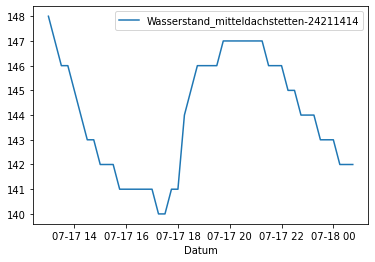

In [49]:
sns.lineplot(data=df_recent.set_index('Datum'))
for list in checkpoints.values():
    
plt.legend()

In [106]:
def plot_recent_html(df, lvls):
    """
    Returns the water level plot html encoded filtered to today.
    """
    # filter df
#     today = dt.datetime.today().date()
#     df_today = df[df.Datum.dt.date == today]
    df_recent = df.head(48)
    
    # set plot
    fig = plt.figure()
#     plt.ion() # don't show plot
    sns.lineplot(data=df_recent.set_index('Datum'))
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(axis='y')
    # plot lvls
    for i,lvl in enumerate(lvls):
        sns.lineplot(x=df_recent.Datum, y=lvl, label=f'Stufe {i+1}')
    
#     plt.close(fig)
    
    # save plot
    tmpfile = BytesIO()
    fig.savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
    plot_html = 'Development last 12 hours:<br><br>' + '<img src=\'data:image/png;base64,{}\'>'.format(encoded) + "<br><br>"
    
    return plot_html

# Send email

In [117]:
def send_email(homename, sender_email, receiver_email, password, port, signature, lvl_results):
    print('send email was called.')
    # check, if there is any alert
    if any([x.get('alert_lvl') for x in lvl_results.values()]):
        print('there is an alert!')
        # compile email msg
        msg = MIMEMultipart('mixed')
        msg['Subject'] = f"{homename} -WATER ALERT- {now}"
        msg['From'] = f'{homename} <{sender_email}>'
        msg['To'] = ','.join(receiver_email)
        
        # init msg
        init = "<p>***ALERT***, <br>Es wurde ein ueberhoehter Wasserstand gemeldet.<br><br></p>"
        # get contents
        today = dt.datetime.today().date()
        
        # unpack dfs
#         tables_html = [x.get('df').head(48).to_html() for x in lvl_results.values()]
        plots_html = [plot_recent_html(vals.get('df'), vals.get('level_list')) for id_, vals in lvl_results.items()]
        alert_levels_html = [f"<p>Alert level {key}: {val.get('alert_lvl')}</p>" for key, val in lvl_results.items()]
    
        # merge all html per checkpoint together
        together = '<br><br>'.join([f'{alert_levels_html[x]}\
                                        <br><br>{plots_html[x]}' for x in range(len(plots_html))])

        # Record the MIME types of text/html.
        text = MIMEMultipart('alternative')
        text.attach(MIMEText(init + together + signature, 'html', _charset="utf-8"))
        
        # create tables as .csv from temp files
        tempdir = tempfile.gettempdir()
        filenames = [f'{tempdir}/{name}.csv' for name in lvl_results.keys()]
        save_files = [value.get('df').head(48).to_csv(f'{tempdir}/{key}.csv') for key, value in lvl_results.items()]
        for file_ in filenames:
            with open(file_, "rb") as fil:
                part = MIMEApplication(
                        fil.read(),
                        Name=basename(file_))
            
            part['Content-Disposition'] = f'attachment; filename={basename(file_)}'
            msg.attach(part)
            
        # add all parts to msg
        msg.attach(text)
        
        # Create a secure SSL context
        context = ssl.create_default_context()

        with smtplib.SMTP_SSL("smtp.gmail.com", port, context=context) as server:
            server.login(sender_email, password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
        
        print(f'successfully sent emails to {receiver_email}')

In [118]:
# send one stat per day
# send alert when overstepping
# email settings
load_dotenv(find_dotenv())
port = 465  # For SSL
GMAIL = os.environ.get("GMAIL")
now = dt.datetime.now().strftime("%y-%m-%d %H:%M:%S")

homename = 'Wasserzeller Muehle'
sender_email = os.environ.get("SENDER")
receiver_email = (os.environ.get("RECEIVER")).split(',') # need list
signature = f"<p>Sources: <br>{'<br>-'.join([base_url.replace('___placeholder___', checkpoint) for checkpoint in checkpoints])}</p>"

In [119]:
# manipulate alert_lvl
hnd_tables['mitteldachstetten-24211414']['alert_lvl'] = 4
hnd_tables['mitteldachstetten-24211414']['alert_lvl']

4

In [120]:
tempdir = tempfile.gettempdir()
f'{tempdir}/mitteldachstetten-24211414.csv'

'/var/folders/fg/10s82l0s4xq7b9ld1yn3k2j80000gn/T/mitteldachstetten-24211414.csv'

send email was called.
there is an alert!
successfully sent emails to ['moritzgeiger@hotmail.de', 'moritz.georg.geiger@gmail.com']


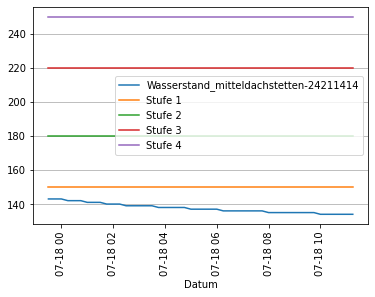

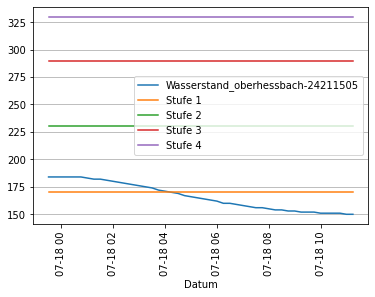

In [121]:
send_email(homename=homename, 
           sender_email=sender_email, 
           receiver_email=receiver_email, 
           password=GMAIL, 
           port=port,
           signature=signature, 
           lvl_results=hnd_tables)

In [ ]:
## TODO: 
# mitteldachstetten und oberhessbach (nicht ansbach) von https://www.hnd.bayern.de
# melde 2: 1 email
# melde 3: 1-2 mails mit warnung


In [124]:
bool('0')

True

In [126]:
"true".lower() in ['true', 'dsf', 'sdf']

True